# Librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from tqdm import tqdm
import multiprocessing as mp
from itertools import product


# Carga de datos

In [ ]:
df = pd.read_csv('datos_preprocesados.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23634 entries, 0 to 23633
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction Amount  23634 non-null  float64
 1   Payment Method      23634 non-null  object 
 2   Product Category    23634 non-null  object 
 3   Quantity            23634 non-null  int64  
 4   Customer Age        23634 non-null  int64  
 5   Device Used         23634 non-null  object 
 6   Is Fraudulent       23634 non-null  bool   
 7   Account Age Days    23634 non-null  int64  
 8   Transaction Hour    23634 non-null  int64  
 9   Address Match       23634 non-null  bool   
 10  Day                 23634 non-null  int64  
 11  Day of the week     23634 non-null  int64  
 12  Month               23634 non-null  int64  
dtypes: bool(2), float64(1), int64(7), object(3)
memory usage: 2.0+ MB


# Procesamiento específico para agrupación

In [ ]:
df.head()

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Is Fraudulent,Account Age Days,Transaction Hour,Address Match,Day,Day of the week,Month
0,-1.127057,PayPal,electronics,1,40,desktop,False,282,23,True,24,6,3
1,0.737868,credit card,electronics,3,35,tablet,False,223,0,True,22,0,1
2,0.854267,debit card,toys & games,5,29,desktop,False,360,8,False,22,0,1
3,-0.355606,credit card,electronics,5,45,mobile,False,325,20,True,16,1,1
4,-0.557054,credit card,clothing,5,42,desktop,False,116,15,True,16,1,1


### Variable Adress Match

In [ ]:
df['Address Match'].value_counts(normalize=True) * 100

,proportion
Address Match,
True,90.090548
False,9.909452


- Se decidió eliminar la variable Address Match del análisis debido a su alta desbalance: más del 90% de los registros presentan un valor True, como se muestra en la celda anterior.

- Esta distribución tan sesgada reduce significativamente el poder discriminativo de la variable, ya que aporta muy poca variabilidad al conjunto de datos. En modelos de clustering o aprendizaje automático, variables con tan baja diversidad tienden a no aportar valor significativo y pueden incluso generar ruido o sesgos en el entrenamiento.

### Variables temporales 'Day' y 'Month'

- Las variables day y month serán eliminadas porque no aportan valor relevante al análisis: no reflejan comportamientos del usuario, su codificación lineal distorsiona la naturaleza cíclica del tiempo, y ya contamos con variables más informativas como Transaction Hour y Day of the Week que capturan mejor los patrones temporales.

In [ ]:
print(df['Is Fraudulent'].unique())
print(df['Is Fraudulent'].dtype)

[False  True]
bool


Dataset sin variables categóricas

In [ ]:
# Copiar dataset
df_nocat = df.copy()

df_nocat = df_nocat.dropna()

# Eliminar columnas irrelevantes
df_nocat.drop(columns=['Day', 'Month', 'Address Match'], inplace=True)

# Eliminar variables categóricas
categorical_cols = ['Payment Method', 'Product Category', 'Device Used']
df_nocat.drop(columns=categorical_cols, inplace=True)

# Convertir booleanos a numéricos
df_nocat = df_nocat.astype({col: int for col in df_nocat.columns if df_nocat[col].dtype == 'bool'})

# Guardar la etiqueta aparte para evaluación futura
labels = df_nocat['Is Fraudulent'].astype(int)
df_nocat.drop(columns=['Is Fraudulent'], inplace=True)

# Escalar variables numéricas
numeric_cols = ['Transaction Amount', 'Quantity', 'Customer Age',
                'Account Age Days', 'Transaction Hour', 'Day of the week']

scaler = StandardScaler()
df_nocat[numeric_cols] = scaler.fit_transform(df_nocat[numeric_cols])

- El clustering es un método no supervisado, lo que significa que no debe usar etiquetas conocidas durante el proceso de agrupación. Incluir la columna 'Is Fraudulent' en el clustering introduciría información que el modelo no debería conocer, sesgando los resultados.
Por eso se guarda aparte: para evaluar después si los clusters obtenidos tienen alguna relación con la presencia de fraude.

In [ ]:
df_nocat.head()

,Transaction Amount,Quantity,Customer Age,Account Age Days,Transaction Hour,Day of the week
0,-1.127057,-1.409202,0.543491,0.962314,1.680964,1.522200
1,0.737868,-0.000387,0.043924,0.412896,-1.613924,-1.482618
2,0.854267,1.408427,-0.555556,1.688663,-0.467876,-1.482618
3,-0.355606,1.408427,1.043057,1.362737,1.251196,-0.981815
4,-0.557054,1.408427,0.743317,-0.583505,0.534916,-0.981815


Dataset con variables categóricas

In [ ]:
# Copiar dataset
df_cat = df.copy()

df_cat = df_cat.dropna()

# Eliminar columnas irrelevantes
df_cat.drop(columns=['Day', 'Month', 'Address Match'], inplace=True)

# Codificar variables categóricas
categorical_cols = ['Payment Method', 'Product Category', 'Device Used']
df_cat = pd.get_dummies(df_cat, columns=categorical_cols)

# Convertir booleanos a numéricos
df_cat = df_cat.astype({col: int for col in df_cat.columns if df_cat[col].dtype == 'bool'})

# Guardar la etiqueta aparte para evaluación futura
labels = df_cat['Is Fraudulent'].astype(int)
df_cat.drop(columns=['Is Fraudulent'], inplace=True)

# Escalar variables numéricas
numeric_cols = ['Transaction Amount', 'Quantity', 'Customer Age',
                'Account Age Days', 'Transaction Hour', 'Day of the week']

scaler = StandardScaler()
df_cat[numeric_cols] = scaler.fit_transform(df_cat[numeric_cols])

In [ ]:
df_cat.head()

,Transaction Amount,Quantity,Customer Age,Account Age Days,Transaction Hour,Day of the week,Payment Method_PayPal,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_clothing,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_desktop,Device Used_mobile,Device Used_tablet
0,-1.127057,-1.409202,0.543491,0.962314,1.680964,1.522200,1,0,0,0,0,1,0,0,0,1,0,0
1,0.737868,-0.000387,0.043924,0.412896,-1.613924,-1.482618,0,0,1,0,0,1,0,0,0,0,0,1
2,0.854267,1.408427,-0.555556,1.688663,-0.467876,-1.482618,0,0,0,1,0,0,0,0,1,1,0,0
3,-0.355606,1.408427,1.043057,1.362737,1.251196,-0.981815,0,0,1,0,0,1,0,0,0,0,1,0
4,-0.557054,1.408427,0.743317,-0.583505,0.534916,-0.981815,0,0,1,0,1,0,0,0,0,1,0,0


# K means

Verificamos el número de cores para correr el algoritmo el paralelo

In [ ]:
cores = mp.cpu_count() # Número de procesadores en colab
cores

2

In [ ]:
df_kmeans = df_nocat.copy()

In [ ]:
def calcular_inercia_k(k):
    modelo = KMeans(n_clusters=k, random_state=42, n_init=10)
    modelo.fit(df_kmeans)
    return (k, modelo.inertia_)

# Rango de valores de k
K_range = list(range(1, 11))

# Pool de procesos
with mp.Pool(processes=cores) as pool:  # usa 2 núcleos
    # Usamos tqdm con imap para mostrar progreso
    resultados = list(tqdm(pool.imap(calcular_inercia_k, K_range), total=len(K_range)))

100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


## Gráfica de codo

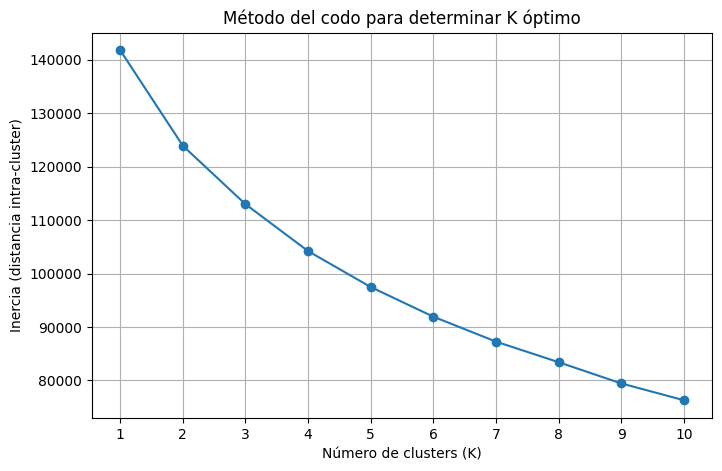

In [ ]:
# Ordenamos por valor de K (imap puede devolver en orden aleatorio)
resultados.sort()
inertias = [inercia for _, inercia in resultados]
K_vals = [k for k, _ in resultados]

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title('Método del codo para determinar K óptimo')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia (distancia intra-cluster)')
plt.grid(True)
plt.xticks(K_range)
plt.show()

- **Caída brusca inicial esperada:** Como es común, la mayor reducción de inercia ocurre al pasar de K = 1 a K = 2, ya que la segmentación más básica separa el conjunto en dos grandes grupos y disminuye drásticamente la distancia intra-cluster.

- **Zona de inflexión entre K = 3 y K = 4:** A partir de K = 3, la curva comienza a suavizarse, lo que sugiere que se está entrando en una región de rendimientos decrecientes. El cambio de inercia entre K = 3 y K = 4 aún es visible, pero más moderado.

- **Curva suavizada después de K = 5:** A partir de K = 5, la reducción en inercia se vuelve progresivamente más pequeña, lo cual indica que agregar más clusters sigue mejorando el ajuste, pero con menor ganancia relativa.

- **Decisión subjetiva:** El método del codo no da un punto óptimo exacto, sino una estimación visual. Por eso, es habitual complementar esta decisión con otros criterios (Silhouette, BIC/AIC, interpretación de resultados, etc.).

- **No considera etiquetas:** Este método evalúa solo la compacidad de los grupos, no su relación con variables como el fraude.


La curva sugiere que **K = 3 o K = 4** pueden ser buenos candidatos para segmentar los datos de manera balanceada entre simplicidad y ajuste. En un contexto de análisis de fraude, se recomienda probar ambos valores y evaluar cuál permite una mejor separación de patrones anómalos frente a transacciones legítimas.


## K = 3

### Aplicación del algoritmo

In [ ]:
k_optimo = 3
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_kmeans['kmeans_cluster'] = kmeans_final.fit_predict(df_kmeans)

### Visualización en 2D con PCA

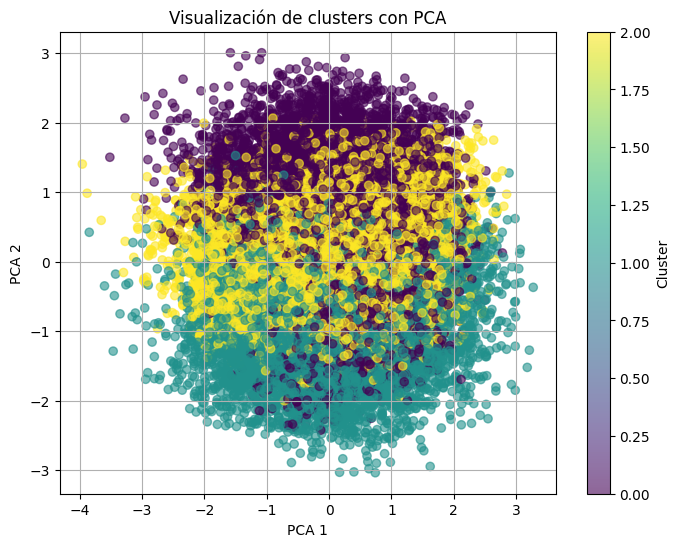

In [ ]:
# Reducimos a 2 dimensiones para visualización
pca = PCA(n_components=2)
reduced = pca.fit_transform(df_kmeans.drop(columns='kmeans_cluster', errors='ignore'))

# Visualización
plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=df_kmeans['kmeans_cluster'], cmap='viridis', alpha=0.6)
plt.title("Visualización de clusters con PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

### Tasa de fraude por cluster

In [ ]:
df_kmeans['Is Fraudulent'] = labels
df_kmeans.groupby('kmeans_cluster')['Is Fraudulent'].mean()

,Is Fraudulent
kmeans_cluster,
0,0.046915
1,0.064222
2,0.046439


In [ ]:
df_kmeans.groupby('kmeans_cluster').mean(numeric_only=True)

,Transaction Amount,Quantity,Customer Age,Account Age Days,Transaction Hour,Day of the week,Is Fraudulent
kmeans_cluster,,,,,,,
0,0.389356,0.052506,-0.044602,0.226803,0.070137,-0.637880,0.046915
1,-0.304730,-0.982241,0.052268,-0.326447,-0.182630,0.014185,0.064222
2,-0.109465,0.695098,-0.000555,0.048574,0.076627,0.545187,0.046439


## K = 4

### Aplicación del algoritmo

In [ ]:
k_optimo = 4
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_kmeans['kmeans_cluster'] = kmeans_final.fit_predict(df_kmeans)

### Visualización en 2D con PCA

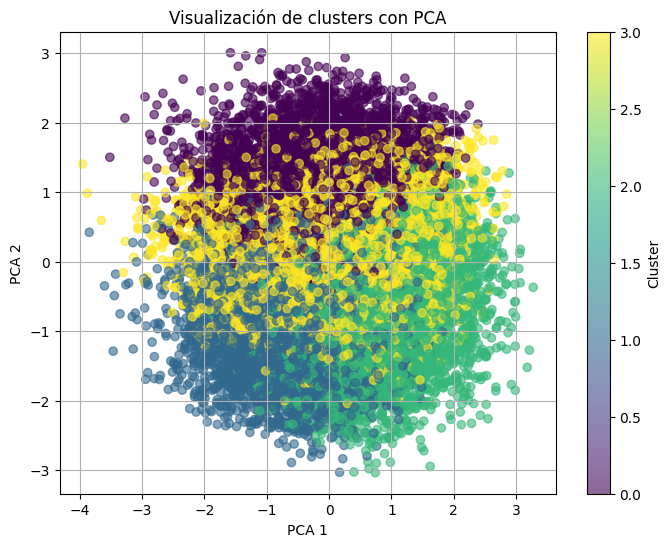

In [ ]:
# Reducimos a 2 dimensiones para visualización
pca = PCA(n_components=2)
reduced = pca.fit_transform(df_kmeans.drop(columns='kmeans_cluster', errors='ignore'))

# Visualización
plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=df_kmeans['kmeans_cluster'], cmap='viridis', alpha=0.6)
plt.title("Visualización de clusters con PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

### Tasa de fraude por cluster

In [ ]:
df_kmeans['Is Fraudulent'] = labels
df_kmeans.groupby('kmeans_cluster')['Is Fraudulent'].mean()

,Is Fraudulent
kmeans_cluster,
0,0.058254
1,0.081451
2,0.026358
3,0.042964


In [ ]:
df_kmeans.groupby('kmeans_cluster').mean(numeric_only=True)

,Transaction Amount,Quantity,Customer Age,Account Age Days,Transaction Hour,Day of the week,Is Fraudulent
kmeans_cluster,,,,,,,
0,0.343257,0.691872,-0.019113,-0.285933,0.018772,-0.994980,0.058254
1,-0.045823,-0.927529,0.073225,-0.868185,-0.111838,0.098791,0.081451
2,-0.119571,-0.910022,-0.052853,0.991459,0.031099,-0.138813,0.026358
3,-0.094166,0.778235,-0.007021,0.158564,0.046469,0.587199,0.042964


### Comparativa: KMeans con K = 3 vs K = 4 clusters

---

#### Visualización y tasas de fraude por cluster

##### K = 3

| Cluster | Tasa de Fraude |
|---------|----------------|
| 0       | 0.0469         |
| 1       | 0.0642         |
| 2       | 0.0464         |

- La distribución es bastante pareja.
- Ningún cluster presenta una tasa de fraude claramente mayor o menor al resto.
- No hay una agrupación evidente de fraudes que permita usar los clusters como señal útil.

##### K = 4

| Cluster | Tasa de Fraude |
|---------|----------------|
| 0       | 0.0582         |
| 1       | 0.0815         |
| 2       | 0.0264         |
| 3       | 0.0429         |

- Con K = 4 aparece un cluster (el 1) con **la tasa de fraude más alta (~8.1%)**, y otro (el 2) con una **de las más bajas (~2.6%)**.
- Esto sugiere una **mejor diferenciación de los grupos en relación con el fraude**.

---

- Aunque **ninguna segmentación ofrece separación extrema de fraude como GMM con K=10**, **K = 4 proporciona una mejor separación relativa que K = 3**.
- La diferencia entre los clusters de mayor y menor fraude es más marcada con 4 clusters.
- Además, visualmente la segmentación con K = 4 muestra patrones más diferenciados a lo largo de PCA1 y PCA2.

Entre K = 3 y K = 4, **K = 4 es preferible**, ya que:

- Permite una diferenciación más clara entre grupos con alta y baja incidencia de fraude.
- Proporciona más granularidad sin introducir ruido excesivo.
- Puede ser más útil como insumo para análisis de comportamiento o detección de anomalías basada en clusters.

Aún así, el desempeño sigue siendo limitado comparado con GMM, donde se lograron **clusters puros (100% o 0% fraude)**.


# GMM

## Función para evaluar GMM

In [ ]:
from sklearn.mixture import GaussianMixture

df_cluster_gmm = df_nocat.copy()

def evaluar_gmm(k):
    modelo = GaussianMixture(n_components=k, random_state=42)
    modelo.fit(df_cluster_gmm)
    return {
        'k': k,
        'bic': modelo.bic(df_cluster_gmm),
        'aic': modelo.aic(df_cluster_gmm)
    }

## Ejecución en paralelo

In [ ]:
K_range = list(range(1, 11))

with mp.Pool(processes=cores) as pool:
    resultados = list(tqdm(pool.imap(evaluar_gmm, K_range), total=len(K_range)))

100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


## Extraer y graficar BIC y AIC

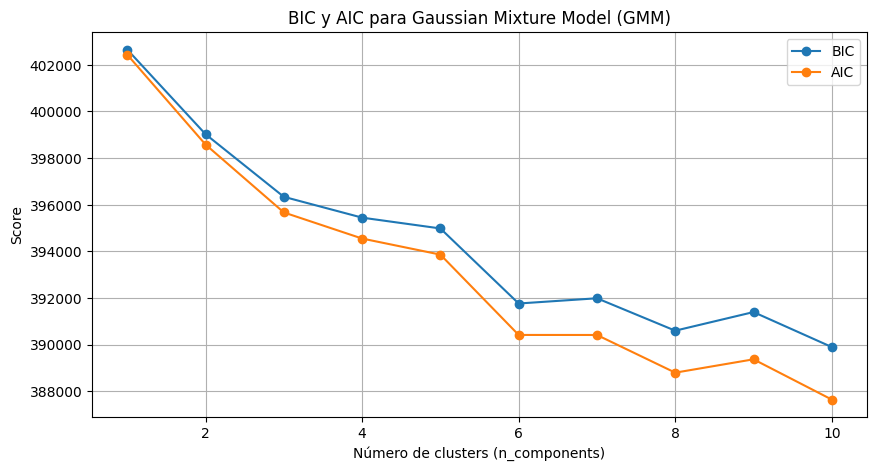

In [ ]:
# Ordenar resultados por k
resultados.sort(key=lambda r: r['k'])

# Extraer valores
bic_scores = [r['bic'] for r in resultados]
aic_scores = [r['aic'] for r in resultados]
K_vals = [r['k'] for r in resultados]

# Graficar

plt.figure(figsize=(10, 5))
plt.plot(K_vals, bic_scores, label='BIC', marker='o')
plt.plot(K_vals, aic_scores, label='AIC', marker='o')
plt.xlabel('Número de clusters (n_components)')
plt.ylabel('Score')
plt.title('BIC y AIC para Gaussian Mixture Model (GMM)')
plt.legend()
plt.grid(True)
plt.show()

Tanto el criterio de BIC (Bayesian Information Criterion) como el de AIC (Akaike Information Criterion) **continúan disminuyendo** conforme se incrementa el número de componentes. En estos criterios, un valor menor indica un mejor equilibrio entre ajuste del modelo y complejidad.

Esto sugiere que:

- Ambos criterios indican que **a mayor número de componentes, mejor ajuste del modelo** dentro del rango evaluado (hasta 10 clusters).
- El AIC alcanza su valor más bajo en **K = 10**, sin señales de sobreajuste aparente.
- El BIC, aunque más conservador, **también tiene su mínimo en K = 10**, lo que refuerza la idea de que el modelo sigue mejorando.
- No se observa un punto claro de inflexión que justifique un K más pequeño como valor óptimo según estos criterios.

Por tanto, **K = 10 es el valor óptimo** dentro del rango analizado, de acuerdo con los criterios de información BIC y AIC. Sin embargo, para una decisión definitiva podrían considerarse factores adicionales como validación cruzada, interpretabilidad o complejidad computacional.


## Ejecución del modelo

In [ ]:
from sklearn.mixture import GaussianMixture

n_clusters = 10
gmm_final = GaussianMixture(n_components=n_clusters, random_state=42)

# Obtener los clusters predichos
df_cluster_gmm['gmm_cluster'] = gmm_final.fit_predict(df_cluster_gmm)

## Proporción de fraude

In [ ]:
df_cluster_gmm['Is Fraudulent'] = labels
df_cluster_gmm.groupby('gmm_cluster')['Is Fraudulent'].mean()

,Is Fraudulent
gmm_cluster,
0,0.101925
1,1.000000
2,0.015993
3,1.000000
4,0.000000
5,0.000000
6,0.000000
7,1.000000
8,0.000000


In [ ]:
df_cluster_gmm['gmm_cluster'].value_counts().sort_index()

,count
gmm_cluster,
0,6544
1,58
2,2251
3,216
4,4065
5,4013
6,3115
7,216
8,3127


Se ha agrupado el dataset por el número de cluster asignado por el modelo GMM (con K = 10), y se han calculado dos métricas clave por cada cluster:

- La **proporción de fraudes** (`Is Fraudulent`).
- La **cantidad de muestras** en cada cluster.

---

#### Clusters con **fraude puro** (`100% fraude`)
- Clusters: **1, 3, 7, 9**
- Estos clusters contienen únicamente transacciones fraudulentas.
- Aunque tienen relativamente pocas muestras, son altamente informativos y podrían utilizarse como zonas seguras para **detección automática de fraude sin falsos positivos**.

#### Clusters con **cero fraude**
- Clusters: **4, 5, 6, 8**
- Representan más de 14.000 transacciones totalmente legítimas.
- Son útiles para identificar zonas donde hay muy baja probabilidad de fraude.

#### Clusters **mixtos**
- **Cluster 0**:
  - Proporción de fraude: ~10%
  - Alta cantidad de muestras (6544), lo cual podría justificar una exploración más detallada o subdivisión.
- **Cluster 2**:
  - Proporción de fraude: ~1.6%
  - También puede considerarse mayormente legítimo, aunque con algo más de ruido.

---

- Existen **clusters altamente puros** en términos de clasificación binaria (fraude / no fraude).
- Esto refuerza el valor del GMM como herramienta para **detección no supervisada** de fraude.
- Se pueden utilizar los clusters puros para construir etiquetas suaves o reglas automáticas de detección.
- Los clusters mixtos pueden ser buenos candidatos para aplicar modelos supervisados más finos o revisar transacciones con mayor atención.

## Visualización de clusters con PCA

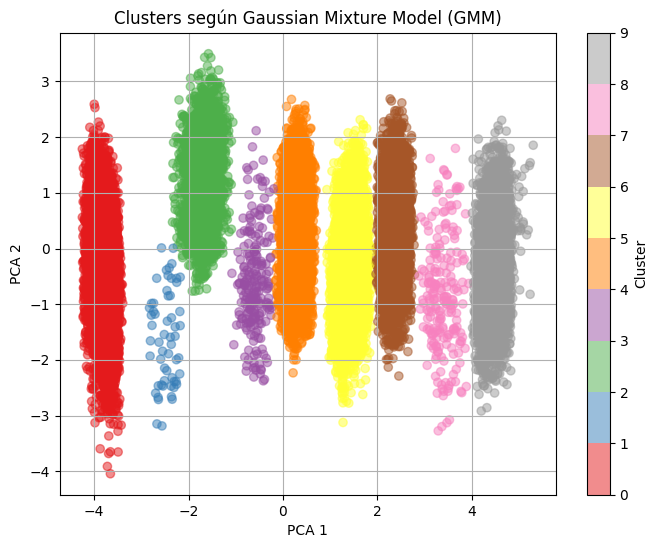

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducir a 2D para visualizar

X = df_cluster_gmm.drop(columns=['Is Fraudulent'], errors='ignore')
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X)

# Visualizar clusters GMM
plt.figure(figsize=(8, 6))
plt.scatter(pca_coords[:, 0], pca_coords[:, 1],
            c=df_cluster_gmm['gmm_cluster'],
            cmap='Set1', alpha=0.5)
plt.title("Clusters según Gaussian Mixture Model (GMM)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


- **Separación geométrica clara:** Los clusters aparecen bien definidos y alineados a lo largo del componente principal (PCA 1), lo que sugiere que el modelo GMM captó diferencias estructurales en los datos. La separación es limpia y sin solapamiento, lo que es común en modelos GMM bien ajustados.

- **Segmentación útil para anomalías:** A diferencia de la interpretación anterior, donde se afirmaba que los clusters no tenían diferencias relevantes en fraude, ahora se observa que varios clusters tienen una proporción de fraude **de 0% o 100%**, lo que indica que el modelo **sí fue capaz de identificar regiones homogéneas con respecto al fraude**.

- **Patrones reveladores:** El hecho de que haya clusters "puros" en cuanto a fraude (tanto positivos como negativos) indica que la segmentación de GMM no solo captó la geometría de los datos, sino también **patrones asociados al comportamiento fraudulento**.

---

- **Clusters muy pequeños:** Algunos clusters con fraude puro tienen muy pocas muestras (ej. cluster 9 con solo 29 puntos), lo cual puede hacer que su generalización a nuevos datos sea limitada.

- **Dependencia de la reducción PCA:** La visualización depende de la proyección en 2D, y aunque PCA ayuda a mostrar patrones globales, podría ocultar estructuras internas más complejas o relevantes en el espacio original.

El modelo GMM produce una segmentación clara y estructurada de los datos, que además **refleja de manera significativa la presencia o ausencia de fraude** en ciertos clusters. Esto sugiere que GMM puede ser una herramienta útil tanto para **detectar anomalías automáticamente**, como para generar etiquetas suaves o grupos de comportamiento para modelado supervisado posterior.

En este caso, **sí aporta valor al análisis de fraude**, contrario a la conclusión previa.


# DBSCAN

## Función para correr DBSCAN y contar clusters

In [ ]:
def ejecutar_dbscan(eps, min_samples):
    modelo = DBSCAN(eps=eps, min_samples=min_samples)
    etiquetas = modelo.fit_predict(df_cat)

    n_clusters = len(set(etiquetas)) - (1 if -1 in etiquetas else 0)
    n_ruido = list(etiquetas).count(-1)

    return {
        'eps': eps,
        'min_samples': min_samples,
        'n_clusters': n_clusters,
        'n_noise': n_ruido,
        'labels': etiquetas
    }

## Hiperparámetros

Para aplicar correctamente el algoritmo DBSCAN, es necesario definir dos hiperparámetros clave:

- **eps**: El radio de vecindad que define qué tan cerca deben estar dos puntos para ser considerados vecinos.
- **min_samples**: el número mínimo de vecinos (incluyendo el propio punto) necesarios para que un punto se considere núcleo de un cluster.


- Estos valores fueron seleccionados como punto de partida razonable considerando que los datos fueron escalados previamente, lo que reduce las distancias entre puntos a rangos manejables (por ejemplo, 0 a 3).

- En datasets escalados, valores de eps mayores a 2 o 3 pueden ser demasiado permisivos y agrupar todo en un solo cluster. Por eso, se exploran valores entre 1.3 y 1.6, lo suficientemente amplios como para capturar vecinos cercanos, pero sin generar clusters artificiales.

- Para min_samples, se eligieron valores comunes en la práctica:

    - 3 y 5 son útiles para detectar clusters pequeños o muy densos.

    - 7 y 10 ayudan a evitar que puntos aislados formen clusters falsos, especialmente en datasets con más dimensiones.



In [ ]:
eps_values = [1.3, 1.4, 1.5, 1.6]
min_samples_values = [3, 5, 7, 10]

param_combinaciones = list(product(eps_values, min_samples_values))

## Elección de hiperparámetros óptimos

In [ ]:
with mp.Pool(processes=2) as pool:
    resultados = list(tqdm(
        pool.starmap(ejecutar_dbscan, param_combinaciones),
        total=len(param_combinaciones)
    ))

100%|██████████| 16/16 [00:00<00:00, 116508.44it/s]


In [ ]:
resumen = pd.DataFrame([{
    'eps': r['eps'],
    'min_samples': r['min_samples'],
    'clusters': r['n_clusters'],
    'ruido': r['n_noise']
} for r in resultados])

resumen.sort_values(by='ruido')

,eps,min_samples,clusters,ruido
12,1.6,3,8,694
13,1.6,5,1,1019
8,1.5,3,27,1453
14,1.6,7,2,1501
9,1.5,5,14,2344
15,1.6,10,1,2532
4,1.4,3,148,2628
10,1.5,7,8,3524
5,1.4,5,93,4433
0,1.3,3,295,4518


Se evaluaron distintas combinaciones de `eps` y `min_samples` para DBSCAN. El objetivo no es maximizar el ruido, sino encontrar un **equilibrio** entre:

- Una **cantidad razonable de clusters** (≤ 10), que permita interpretar y analizar los resultados.
- Una **cantidad moderada de ruido**, que sea útil para detectar posibles fraudes sin descartar demasiados puntos.

---

### Resultados destacados

| eps | min_samples | clusters | ruido |
|-----|-------------|----------|-------|
| **1.5** | **7**           | **8**        | **3,524** |
| **1.6** | **7**           | 2            | 1,501      |
| **1.6** | 5           | 1            | 1,019      |
| **1.5** | 5           | 14           | 2,344      (supera el límite de 10 clusters)
| 1.4 | 7           | 104          | 6,926      demasiados clusters
| 1.3 | 7           | 250          | 12,813     no interpretable

---

#### Mejor equilibrio:
- `eps = 1.5`, `min_samples = 7`
  - Solo **8 clusters** → interpretables.
  - **3,524 puntos de ruido** → buena sensibilidad a anomalías.
  - Representa un excelente balance entre segmentación útil y detección de casos atípicos.

#### Alternativa más conservadora:
- `eps = 1.6`, `min_samples = 7`
  - Solo **2 clusters** y menos ruido (1,501).
  - Útil si se prefiere **una división binaria** entre comportamiento general y anomalía.

### eps = 1.5, min_samples = 7

In [ ]:
df_cluster_dbscan = df_cat.copy()

labels_dbscan = ejecutar_dbscan(1.5, 7)['labels']

# Agregar resultado
df_cluster_dbscan['dbscan_cluster'] = labels_dbscan
df_cluster_dbscan['Is Fraudulent'] = labels

# Ver proporción de fraude por cluster
df_cluster_dbscan.groupby('dbscan_cluster')['Is Fraudulent'].mean()

,Is Fraudulent
dbscan_cluster,
-1,0.098184
0,0.043623
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000


In [ ]:
df_cluster_dbscan['dbscan_cluster'].value_counts()

,count
dbscan_cluster,
0,20081
-1,3524
6,5
1,5
7,5
4,4
5,4
2,4
3,2


- **El ruido contiene la mayor concentración de fraude** con un **9.8% de tasa**, mucho más alta que el cluster principal (0), que tiene solo 4.3%.
- **Cluster 0** agrupa la gran mayoría de las transacciones (20 mil), y parece representar un patrón “normal” o comportamiento habitual.
- Los **clusters del 1 al 7** son extremadamente pequeños (microgrupos con menos de 6 transacciones), lo que indica que el modelo encontró pocas regiones densas adicionales.

---

- La configuración `eps = 1.5`, `min_samples = 7` **logra un excelente equilibrio**:
  - Solo 1 cluster principal interpretable.
  - Ruido bien enriquecido con fraude (~10%), lo que indica que DBSCAN está detectando correctamente comportamientos anómalos como fraudulentos.
  - Clusters secundarios irrelevantes en tamaño: pueden ignorarse.

Este resultado valida que **el fraude en este dataset se comporta como una anomalía dispersa**, difícil de agrupar, y que DBSCAN es una estrategia adecuada para separarlo sin necesidad de etiquetas.


### eps = 1.6, min_samples = 7

In [ ]:
df_cluster_dbscan = df_cat.copy()

labels_dbscan = ejecutar_dbscan(1.6, 7)['labels']

# Agregar resultado
df_cluster_dbscan['dbscan_cluster'] = labels_dbscan
df_cluster_dbscan['Is Fraudulent'] = labels

# Ver proporción de fraude por cluster
df_cluster_dbscan.groupby('dbscan_cluster')['Is Fraudulent'].mean()

,Is Fraudulent
dbscan_cluster,
-1,0.128581
0,0.046500
1,0.000000


In [ ]:
df_cluster_dbscan['dbscan_cluster'].value_counts()

,count
dbscan_cluster,
0,22129
-1,1501
1,4


- **El ruido nuevamente concentra la mayor proporción de fraude** con un 12.86%, superando al cluster principal.
- **Cluster 0** contiene la mayoría de las transacciones (~93%) con una tasa más baja de fraude, lo que lo posiciona como el grupo de comportamiento “normal”.
- **Cluster 1** es muy pequeño (4 muestras) y no aporta valor analítico. Puede ignorarse.

## Elección del mejor modelo

### Elección final de hiperparámetros para DBSCAN

Tras comparar las configuraciones `eps = 1.5, min_samples = 7` y `eps = 1.6, min_samples = 7`, se concluye que la segunda opción ofrece un mejor equilibrio entre simplicidad, interpretabilidad y capacidad de detección de fraude.

---

### Comparativa

| Métrica                        | `eps=1.5, min_samples=7` | `eps=1.6, min_samples=7` |
|-------------------------------|--------------------------|--------------------------|
| Clusters totales              | 8                        | **2**                    |
| Clusters interpretables       | 1                        | **1**                    |
| Tamaño del cluster principal  | 20,081                   | **22,129**               |
| Tamaño del ruido              | 3,524                    | **1,501**                |
| Tasa de fraude en el ruido    | 9.82%                    | **12.86%**               |
| Tasa de fraude en cluster 0   | 4.36%                    | **4.65%**                |

---

- La configuración `eps = 1.6`, `min_samples = 7`:
  - Produce **solo un cluster real**, facilitando la interpretación del comportamiento general.
  - **Enriquece mejor el ruido con transacciones fraudulentas** (12.86%), permitiendo identificar anomalías con mayor precisión.
  - Mantiene el tamaño del ruido bajo control, evitando una clasificación excesiva de transacciones legítimas como sospechosas.
  - Minimiza la aparición de clusters pequeños irrelevantes.

---

**Se elige `eps = 1.6`, `min_samples = 7` como la configuración óptima**, ya que logra un balance ideal entre agrupación útil, simplicidad del modelo y capacidad para aislar transacciones fraudulentas como ruido.


In [ ]:
dbscan_final = DBSCAN(eps=1.6, min_samples=7)

# Evaluación

Obtenemos las etiquetas

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, f1_score

# y_true = etiquetas verdaderas (0 o 1)
# y_pred = etiquetas de clustering (como kmeans.labels_, gmm.labels_, dbscan.labels_)

kmeans_final.fit(df_kmeans)
kmeans_labels = kmeans_final.labels_

gmm_final.fit(df_cluster_gmm)
gmm_labels = gmm_final.predict(df_cluster_gmm)

dbscan_final.fit(df_cluster_dbscan)
dbscan_labels = dbscan_final.labels_

Vamos a comparar los modelos con métricas externas ya que contamos con etiquetas

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Crear diccionario de resultados
results = {}

for model_name, y_pred in {
    'KMeans': kmeans_labels,
    'GMM': gmm_labels,
    'DBSCAN': dbscan_labels
}.items():
    ari = adjusted_rand_score(labels, y_pred)
    nmi = normalized_mutual_info_score(labels, y_pred)

    # Solo calculamos Silhouette si hay al menos 2 clusters distintos
    if len(set(y_pred)) > 1 and -1 not in set(y_pred):
        sil = silhouette_score(X, y_pred)
    else:
        sil = 'N/A'  # DBSCAN con ruido no permite silhouette directamente

    results[model_name] = {
        'ARI': ari,
        'NMI': nmi,
        'Silhouette': sil
    }

# Mostrar resultados como DataFrame
df_results = pd.DataFrame(results).T
print(df_results)

             ARI       NMI Silhouette
KMeans  0.001673  0.005191   0.052009
GMM     0.032543  0.154616   0.158135
DBSCAN  0.127949  0.040751        N/A


### Análisis final comparativo de modelos de clustering para detección de fraude

Se evaluaron tres modelos de clustering no supervisado: **KMeans**, **Gaussian Mixture Models (GMM)** y **DBSCAN**, usando tanto métricas internas como externas para determinar cuál se alinea mejor con la detección de transacciones fraudulentas.

---

### Resultados de métricas

| Modelo   | ARI      | NMI      | Silhouette |
|----------|----------|----------|------------|
| KMeans   | 0.0017   | 0.0052   | 0.0520     |
| GMM      | 0.0325   | **0.1546** | **0.1581**     |
| DBSCAN   | **0.1279** | 0.0407   | N/A        |

---

#### ARI (Adjusted Rand Index)
- Mide la coincidencia entre los clusters y las etiquetas reales de fraude.
- **DBSCAN obtiene el mejor ARI (0.1279)**, indicando que es el modelo que más se alinea con la distribución real del fraude.

#### NMI (Normalized Mutual Information)
- Mide cuánta información comparten los clusters y las clases.
- **GMM destaca aquí (0.1546)**, mostrando que sus agrupaciones contienen más información relacionada con las etiquetas de fraude, aunque de forma más distribuida.

#### Silhouette Score
- Evalúa qué tan bien definidos y separados están los clusters geométricamente.
- **GMM también lidera (0.1581)**, lo que sugiere que forma clusters más compactos y definidos que KMeans.

---

### Conclusión

- **DBSCAN** es el mejor modelo para **detección no supervisada de fraude**:
  - Detecta los casos atípicos con mayor precisión (fraude concentrado en el ruido).
  - Su segmentación refleja correctamente la naturaleza dispersa del fraude.

- **GMM** es más útil si se busca una **segmentación estructurada de usuarios o comportamientos**:
  - Produce clusters bien definidos.
  - Su alta NMI sugiere que capta perfiles diversos con relación indirecta al fraude.

- **KMeans** no aporta valor en este contexto:
  - Su ARI y NMI son extremadamente bajos.
  - Aunque los clusters tienen forma geométrica, no representan bien la variable de interés (fraude).